In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate

from api.utils import load_data, PropertyDataTransformer

In [ ]:
X, y = load_data(wards=['kita', 'itabashi'])

pt = PropertyDataTransformer(formula = """
price ~
is_house +
(
    is_new +
    date +
    C(building_type, contr.treatment('NA')) +
    C(building_type, contr.treatment('NA')):age
):house_m2 +
(
    date +
    nearest_station_name +
    nearest_station_minutes +
    road +
    C(floor_ratio, contr.treatment('150.0')) +
    C(building_ratio, contr.treatment('60.0')) +
    C(orientation, contr.treatment('東')) +
    C(land_shape, contr.treatment('正方形'))
):land_m2
- 1
""")
X = pt.fit_transform(X)

In [ ]:
model = LassoCV(alphas=[0.1, 1, 10, 100, 1000, 10000], max_iter=10000, tol=0.1, fit_intercept=False)
# scores = pd.DataFrame(
#     cross_validate(
#         model,
#         X, y,
#         scoring=['r2', 'neg_mean_absolute_percentage_error'],
#         return_train_score=True,
#         cv=500
#     )
# )
model.fit(X, y)
scores.apply([np.mean, np.median], axis=0).T

,mean,median
fit_time,0.128302,0.108533
score_time,0.003585,0.002398
test_r2,0.345416,0.589493
train_r2,0.660607,0.660570
test_neg_mean_absolute_percentage_error,-0.311399,-0.215933
train_neg_mean_absolute_percentage_error,-0.303210,-0.303378


[(-1.0, 0.0)]

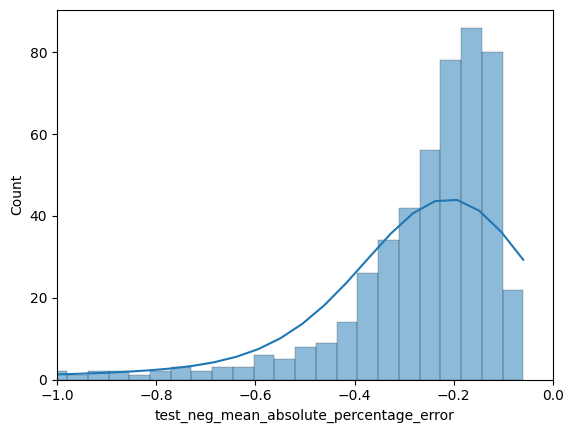

In [4]:
h = sns.histplot(data=scores, x='test_neg_mean_absolute_percentage_error', kde=True)
h.set(xlim=(-1, 0))

In [5]:
s = pd.DataFrame({
    'coef': X.columns,
    'value': model.coef_
})
s.sort_values('value').style.format("{:}")
# s[~s['coef'].str.contains('area|nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('nearest')].sort_values('value').style.format("{:}")
s[s['coef'].str.contains('building_type')].sort_values('value').style.format("{:}")


,coef,value
96,"C(building_type, contr.treatment('NA'))[鉄骨造]:age:house_m2",-10775.753118212473
100,"C(building_type, contr.treatment('NA'))[ＲＣ、鉄骨造、木造]:age:house_m2",-10719.977025224027
98,"C(building_type, contr.treatment('NA'))[ＲＣ]:age:house_m2",-10705.541548009756
97,"C(building_type, contr.treatment('NA'))[鉄骨造、木造]:age:house_m2",-10375.289667766086
95,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2",-9947.3533324108
94,"C(building_type, contr.treatment('NA'))[木造]:age:house_m2",-8315.183589280963
4,"C(building_type, contr.treatment('NA'))[ブロック造]:house_m2",-7581.293164761079
93,"C(building_type, contr.treatment('NA'))[ブロック造]:age:house_m2",-6483.3119438322365
99,"C(building_type, contr.treatment('NA'))[ＲＣ、木造]:age:house_m2",-5145.1453054527365
101,"C(building_type, contr.treatment('NA'))[ＳＲＣ]:age:house_m2",-4580.578297559576


In [ ]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'area_name': '王子',
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': 60.0,
    'floor_ratio': 150.0,
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)
x

In [ ]:
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'y_pred': model.predict(X),
    'y_true': y,
    'is_house': X.is_house
})
sns.scatterplot(data, x='y_pred', y='y_true', hue='is_house', alpha=0.5)
sns.lineplot(data, x='y_true', y='y_true')

yp = model.predict(x)[0]
plt.scatter(yp, yy, c='r', linewidths=20)

plt.title(f'{yy / yp - 1:.1%} compared to prediction = {yp / 10000:,.0f}万円')
plt.xlim(0, 2e8)
plt.ylim(0, 2e8)

In [ ]:
import joblib

joblib.dump(pt, 'proptrans.pkl')
joblib.dump(model, 'model.pkl')
s.to_csv('coef_.csv', index=False)